In [70]:
import datetime
import os
from dateutil.relativedelta import *
import matplotlib.pylab as plt
import matplotlib as mpl
from PIL import Image
import numpy as np

In [71]:
def simple_plot_index(a,title=""):
    fig, ax = plt.subplots()

    #cmap='RdBu'
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red","orange","yellow","white","pink","violet", "#0f0f0f"])
    plt.title(title)
    im = plt.imshow(a, interpolation='none',cmap=cmap)
    plt.colormaps()
    # cbar = fig.colorbar(cax,ticks=[-1, 0, 1, 2, 10],orientation='vertical')
    cbar = fig.colorbar(im, orientation='vertical')
    #plt.clim(-3,3)
    # cbar.ax.set_yticklabels(['< -1', '0', 1, 2,'> 10'])# vertically oriented
    # colorbar
    #ax.format_coord = Formatter(im)
    plt.show()

def MaskMR (IndMap,MRmap,mrID):
    val=int(mrID)
    IndMap[MRmap!=val] = np.nan
    return IndMap

def main (oDateFrom,oDateTo,mr_val):
    
    list_nivZero = []
    list_nivA = []
    list_nivB = []
    list_nivC = []
    list_nivD = []
    
    while (oDateFrom <= oDateTo):

        print (oDateFrom)
        
        ##### IMPORT MACROREGION
        MR_file= os.path.join(products_dir,"Macroregions_BOL.tif")
        MR_I = Image.open(MR_file)
        MR = np.array(MR_I)
        #MR[MR==255]=np.nan
        
        ######## METEO

        if INDEX_METEO=="SPI":
            prefix= INDEX_METEO + accumulation_METEO + "-PERSIANN_"
        elif INDEX_METEO=="SPEI":
            prefix= INDEX_METEO + accumulation_METEO + "-PERSIANN-MODIS_"

        METEO_file= os.path.join(products_dir,INDEX_METEO,oDateFrom.strftime("%Y"),oDateFrom.strftime("%m"),prefix+oDateFrom.strftime("%Y%m")+".tif")

        METEO_I = Image.open(METEO_file)
        
        METEO = np.array(METEO_I)

        #simple_plot_index (METEO,prefix+oDateFrom.strftime("%Y%m"))

        combined = METEO * 0

        METEO=(METEO<METEO_threshold)*1

        combined = combined + (METEO)

        ######## SOIL MOISTURE

        if INDEX_HUM=="PDSI":
            prefix= INDEX_HUM + accumulation_HUM + "-PERSIANN-MODIS-SMAP_"
        else:
            prefix= INDEX_HUM + accumulation_HUM + "-SMAP_"
        
        SMI_file= os.path.join(products_dir,INDEX_HUM,oDateFrom.strftime("%Y"),oDateFrom.strftime("%m"),prefix+oDateFrom.strftime("%Y%m")+".tif")

        SMI_I = Image.open(SMI_file)
        
        SMI = np.array(SMI_I)

        HUM=(SMI<HUM_threshold)*1

        #simple_plot_index (HUM,prefix_HUM+oDateFrom.strftime("%Y%m"))

        combined = (combined + (HUM))
        
        ######## VEGETATION

        prefix= INDEX_VEG + accumulation_VEG + "-MODIS_" #FAPAR e VHI have the same

        VEG_file= os.path.join(products_dir,INDEX_VEG,oDateFrom.strftime("%Y"),oDateFrom.strftime("%m"),prefix+oDateFrom.strftime("%Y%m")+".tif")

        VEG_I = Image.open(VEG_file)
        
        VEG = np.array(VEG_I)
        
        VEG=(VEG<VEG_threshold)*1

        #simple_plot_index (VEG,prefix_VEG+oDateFrom.strftime("%Y%m"))

        combined = combined + (VEG)
        
        ######## VEGETATION2

        prefix= INDEX_VEG2 + accumulation_VEG2 + "-MODIS_" #FAPAR e VHI have the same

        VEG_file2= os.path.join(products_dir,INDEX_VEG2,oDateFrom.strftime("%Y"),oDateFrom.strftime("%m"),prefix+oDateFrom.strftime("%Y%m")+".tif")

        VEG_II = Image.open(VEG_file2)
        
        VEGII = np.array(VEG_II)
        
        VEGII = (VEGII<VEG_threshold2)*1

        combined = combined + (VEGII)
        
        # MASK on MacroRegion
        if mr_val > 0:
            combined = MaskMR(combined,MR,mr_val) 
        
        # PLOT combined

        fig, ax = plt.subplots()
        cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","yellow","orange","red"])
        im = plt.imshow(combined, interpolation='none',cmap=cmap)
        plt.title("combined_"+oDateFrom.strftime("%Y%m"))
        plt.colormaps()
        # cbar = fig.colorbar(cax,ticks=[-1, 0, 1, 2, 10],orientation='vertical')
        cbar = fig.colorbar(im, orientation='vertical')
        plt.clim(0,4)
        # cbar.ax.set_yticklabels(['< -1', '0', 1, 2,'> 10'])# vertically oriented
        #ax.format_coord = Formatter(im)
        plt.show()

        # combined drought indicator
        # Get number of data per level
        if mr_val > 0:
            dim = np.count_nonzero(MR == mr_val)
        else:
            dim = combined.shape[0]*combined.shape[1]

        # Level 0
        nivZero = (np.count_nonzero(combined == 0)/dim)*100
        list_nivZero.append(nivZero)
        # Level 1
        nivA = (np.count_nonzero(combined == 1)/dim)*100
        list_nivA.append(nivA)
        # Level 2
        nivB = (np.count_nonzero(combined == 2)/dim)*100
        list_nivB.append(nivB)
        # Level 3
        nivC = (np.count_nonzero(combined == 3)/dim)*100
        list_nivC.append(nivC)
        # Level 4
        nivD = (np.count_nonzero(combined == 4)/dim)*100
        list_nivD.append(nivD)        
        
        oDateFrom = oDateFrom +relativedelta(months=+1)
    
    plt.plot(list_nivZero, label='Nivel 0')
    plt.plot(list_nivA, label='Nivel 1')
    plt.plot(list_nivB, label='Nivel 2')
    plt.plot(list_nivC, label='Nivel 3')
    plt.plot(list_nivD, label='Nivel 4')
    plt.ylabel("Porcentaje [%]")
    plt.ylim(0, 100)
    plt.legend()
    plt.title("Desarrollo de los niveles de criticidad de sequias")
    
    print('Process ended with success')


2016-01-01 00:00:00


/Users/al/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less
/Users/al/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in less
/Users/al/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in less
/Users/al/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in less


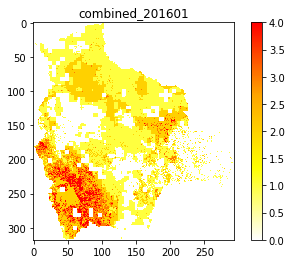

2016-02-01 00:00:00


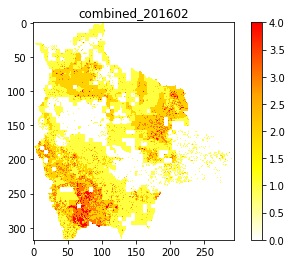

2016-03-01 00:00:00


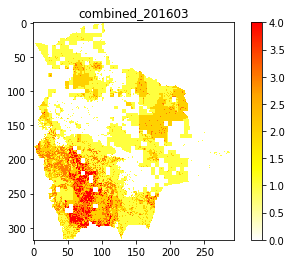

2016-04-01 00:00:00


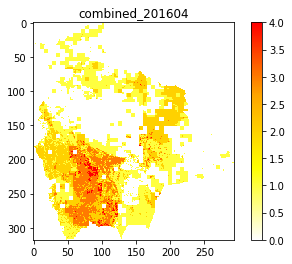

2016-05-01 00:00:00


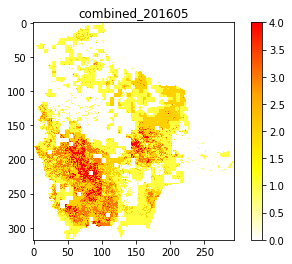

2016-06-01 00:00:00


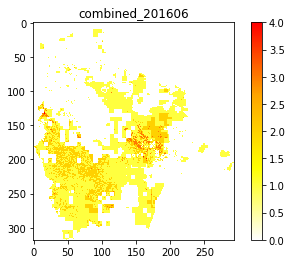

2016-07-01 00:00:00


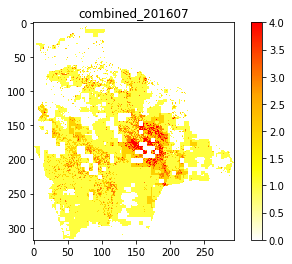

2016-08-01 00:00:00


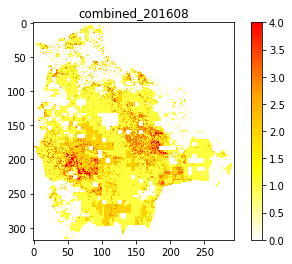

2016-09-01 00:00:00


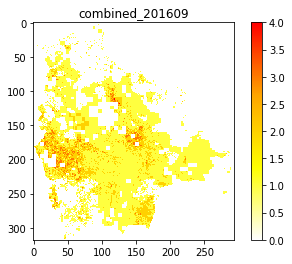

2016-10-01 00:00:00


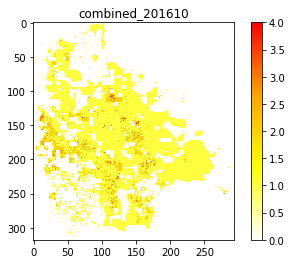

2016-11-01 00:00:00


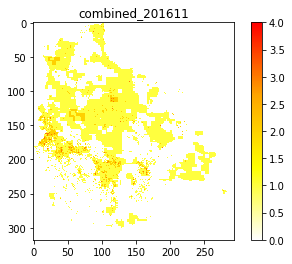

2016-12-01 00:00:00


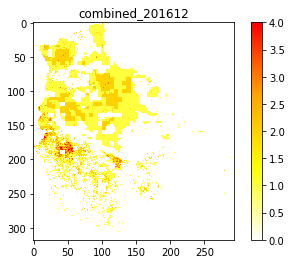

Process ended with success

2020-06-25 21:48:39.040253 - Process ended.



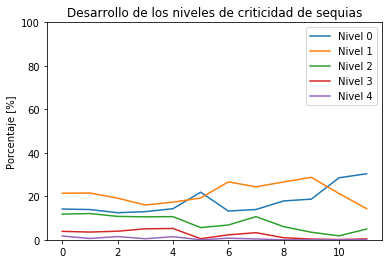

In [72]:
if __name__ == "__main__":

    #################################################################

    tmp_dir = "tmp"
    products_dir = "productos"

    #################################################################

    sDateFrom = '201601' # Fecha inicio
    oDateFrom = datetime.datetime.strptime(sDateFrom,"%Y%m")

    sDateTo = '201612' # Fecha Fin
    oDateTo = datetime.datetime.strptime(sDateTo,"%Y%m")

    #################################################################

    INDEX_METEO="SPI" #SPI or SPEI
    accumulation_METEO = "06" # SPI=01,02,03,06 or SPEI=01,03,06
    METEO_threshold = -1.3

    INDEX_HUM="SWDI" #SWDI or SSMI or PDSI
    accumulation_HUM = "06" #SWDI/SSMI=01,03,06 or PDSI=[none]
    HUM_threshold=-1

    INDEX_VEG="VHI" #FAPAR or ESI or VHI
    accumulation_VEG = "02" #FAPAR/ESI/VHI=01,03,06
    VEG_threshold=0.2

    INDEX_VEG2="VHI" # FAPAR, VHI, ESI
    accumulation_VEG2 = "01" #FAPAR/ESI/VHI=01,03,06
    VEG_threshold2=0.05
    
    mr_val = -1 # -1: Bolivia, 1: Yungas-Chapare, 2: Valles, 3: Llanuras-Sabanas, 4: Chiquitania, 5: Chaco, 6: Amazonia, 7: Altiplano

    #################################################################

    main(oDateFrom,oDateTo,mr_val)
    print('\n' + str(datetime.datetime.now()) + ' - Process ended.\n')